In [15]:
import os
import pandas as pd
import numpy as np
import yaml
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.spatial.distance as distance

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from negativeSelection import (NegativeSelection, 
                                RChunkNSA,
                                signal2string,
                                generate_string,
                                calculate_r_contiguous_matches,
                                calculate_hamming,
                                calculate_rogerstanimoto,
                                match_r_contiguous,
                                match_hamming,
                                match_rogerstanimoto)

SENSOR = "temperature"

WRANGLE_PATH = "../data/experiment4/wrangle/"
FINAL_FEATURES_YAML = r"C:\Users\araujo\Documents\PhD\AIS\code\files\config\final_features_temperature.yaml"

# Import dataset

In [16]:
train = pd.read_parquet(os.path.join(WRANGLE_PATH, f'{SENSOR}_train_fxd.parquet'))
test = pd.read_parquet(os.path.join(WRANGLE_PATH, f'{SENSOR}_test_fxd.parquet'))

In [17]:
X_train = train.fillna(0).astype(int)
y_train = train.is_property_violation

In [18]:
X_test = test.fillna(0).astype(int)
y_test = test.is_property_violation

In [19]:
with open(FINAL_FEATURES_YAML, "r") as stream:
    try:
        signal_cols = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
print(signal_cols)

['temperature_was_available_during_transfered', 'temperature_transfered', 'temperature_was_available_during_centralhub_temperature_processed', 'temperature_battery_became_unavailable_during_trace', 'temperature_context_became_unavailable_during_trace', 'temperature_battery_became_unavailable_during_processed', 'temperature_battery_became_unavailable_during_transfered', 'temperature_battery_became_unavailable_during_collected', 'temperature_processed', 'abpd_sig_battery_on_min', 'heartrate_sig_battery_on_min', 'oximeter_sig_battery_on_min', 'abps_sig_battery_on_min']


In [20]:
X_train.filter(signal_cols).T

,0,1,2,3,4,5,6,7,8,9,...,14962,14963,14964,14965,14966,14967,14968,14969,14970,14971
temperature_was_available_during_transfered,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,0,1
temperature_transfered,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,0,1
temperature_was_available_during_centralhub_temperature_processed,1,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,0,1,0,0
temperature_battery_became_unavailable_during_trace,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
temperature_context_became_unavailable_during_trace,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,1
temperature_battery_became_unavailable_during_processed,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
temperature_battery_became_unavailable_during_transfered,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
temperature_battery_became_unavailable_during_collected,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
temperature_processed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
abpd_sig_battery_on_min,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [21]:
X_test.filter(signal_cols).T

,0,1,2,3,4,5,6,7,8,9,...,5014,5015,5016,5017,5018,5019,5020,5021,5022,5023
temperature_was_available_during_transfered,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
temperature_transfered,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
temperature_was_available_during_centralhub_temperature_processed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0
temperature_battery_became_unavailable_during_trace,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
temperature_context_became_unavailable_during_trace,0,1,0,0,0,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
temperature_battery_became_unavailable_during_processed,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
temperature_battery_became_unavailable_during_transfered,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
temperature_battery_became_unavailable_during_collected,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
temperature_processed,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
abpd_sig_battery_on_min,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


# R-Chunk

## 5-chunk

### 100 detectors

In [44]:
ns_chunk = RChunkNSA(r=5, n_detectors=100, alphabet=['0','1'])

In [45]:
ns_chunk.fit(X_train.filter(signal_cols), y_train)

In [46]:
y_pred = ns_chunk.predict(X_test.filter(signal_cols))

<AxesSubplot:>

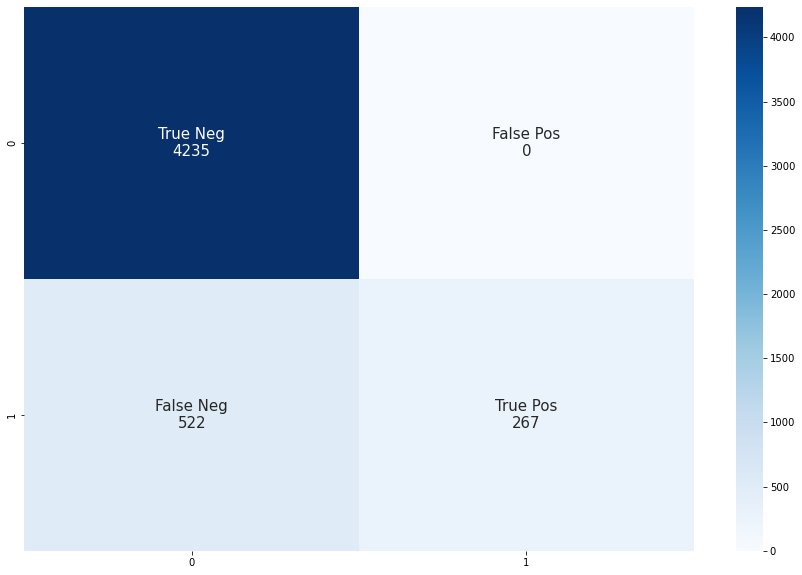

In [47]:
fig, ax = plt.subplots(figsize=(15,10))

cf_matrix = confusion_matrix(y_test, y_pred)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in
#                      cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]#,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', annot_kws={"fontsize":15})

In [48]:
# print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      4235
           1       1.00      0.34      0.51       789

    accuracy                           0.90      5024
   macro avg       0.95      0.67      0.72      5024
weighted avg       0.91      0.90      0.87      5024



### 1000 detectors

In [22]:
ns_chunk_5_1000 = RChunkNSA(r=5, n_detectors=1000, alphabet=['0','1'])

In [23]:
ns_chunk_5_1000.fit(X_train.filter(signal_cols), y_train)

In [24]:
y_pred = ns_chunk_5_1000.predict(X_test.filter(signal_cols))

<AxesSubplot:>

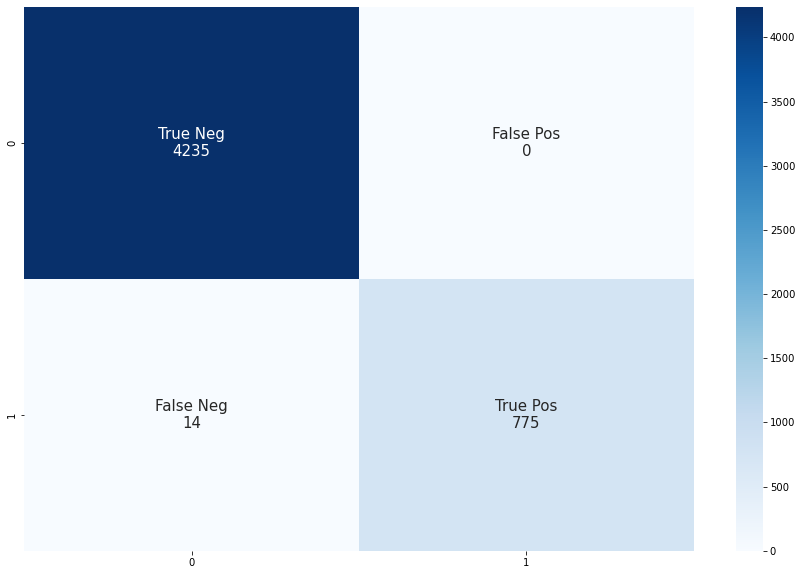

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

cf_matrix = confusion_matrix(y_test, y_pred)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
# group_percentages = ["{0:.2%}".format(value) for value in
#                      cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]#,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues', annot_kws={"fontsize":15})

In [26]:
# print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4235
           1       1.00      0.98      0.99       789

    accuracy                           1.00      5024
   macro avg       1.00      0.99      0.99      5024
weighted avg       1.00      1.00      1.00      5024



# Saving Model

In [27]:
ns_chunk_5_1000.nonself_detectors.to_csv(os.path.join(WRANGLE_PATH, f'{SENSOR}_ns_chunk_5_1000_detectors.csv'), index=False)

In [30]:
filename = os.path.join(WRANGLE_PATH, f'{SENSOR}_ns_chunk_5_1000_20230612.sav')
joblib.dump(ns_chunk_5_1000, filename)

['../data/experiment4/wrangle/temperature_ns_chunk_5_1000_20230612.sav']

In [31]:
ns = joblib.load(filename)

In [ ]:
import pickle
pickle.dump(ns_chunk_5_1000, open(filename, 'wb'))

In [29]:
len(ns_chunk_5_1000.nonself_detectors)

229